In [1]:
%matplotlib inline

In [2]:
%matplotlib notebook
import multiprocessing as mp
mp.set_start_method('forkserver')

In [3]:
import torch.nn.functional as F
import torch
torch.cuda.set_device(1)
import torch.nn as nn
from torch.nn.utils import weight_norm, spectral_norm
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import numpy as np
import numpy as np 
from matplotlib import pyplot as plt
from torch.optim import *
from InvertibleResnet import *

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [   transforms.Pad(2),
        transforms.ToTensor(),     
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

In [ ]:
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=True, num_workers=2)

In [ ]:
testnet = InvertibleResnetConv(1,32, list_num_blocks=(32,32,32)).cuda()

In [ ]:
b = testnet(next(iter(trainloader))[0].cuda(), return_logdet=True)

In [ ]:
from torch.distributions import *
std = 1
ndim = 32*32
n_bins = 5
gaussian = Normal(0.0,std)
normal_np = gaussian.sample((20000,2)).numpy()

In [ ]:
net = InvertibleResnetConv(1,32, list_num_blocks=(32,32,32)).cuda()
optim = Adam(net.parameters(), lr=0.0003, betas=(0.1,0.9))

<IPython.core.display.Javascript object>


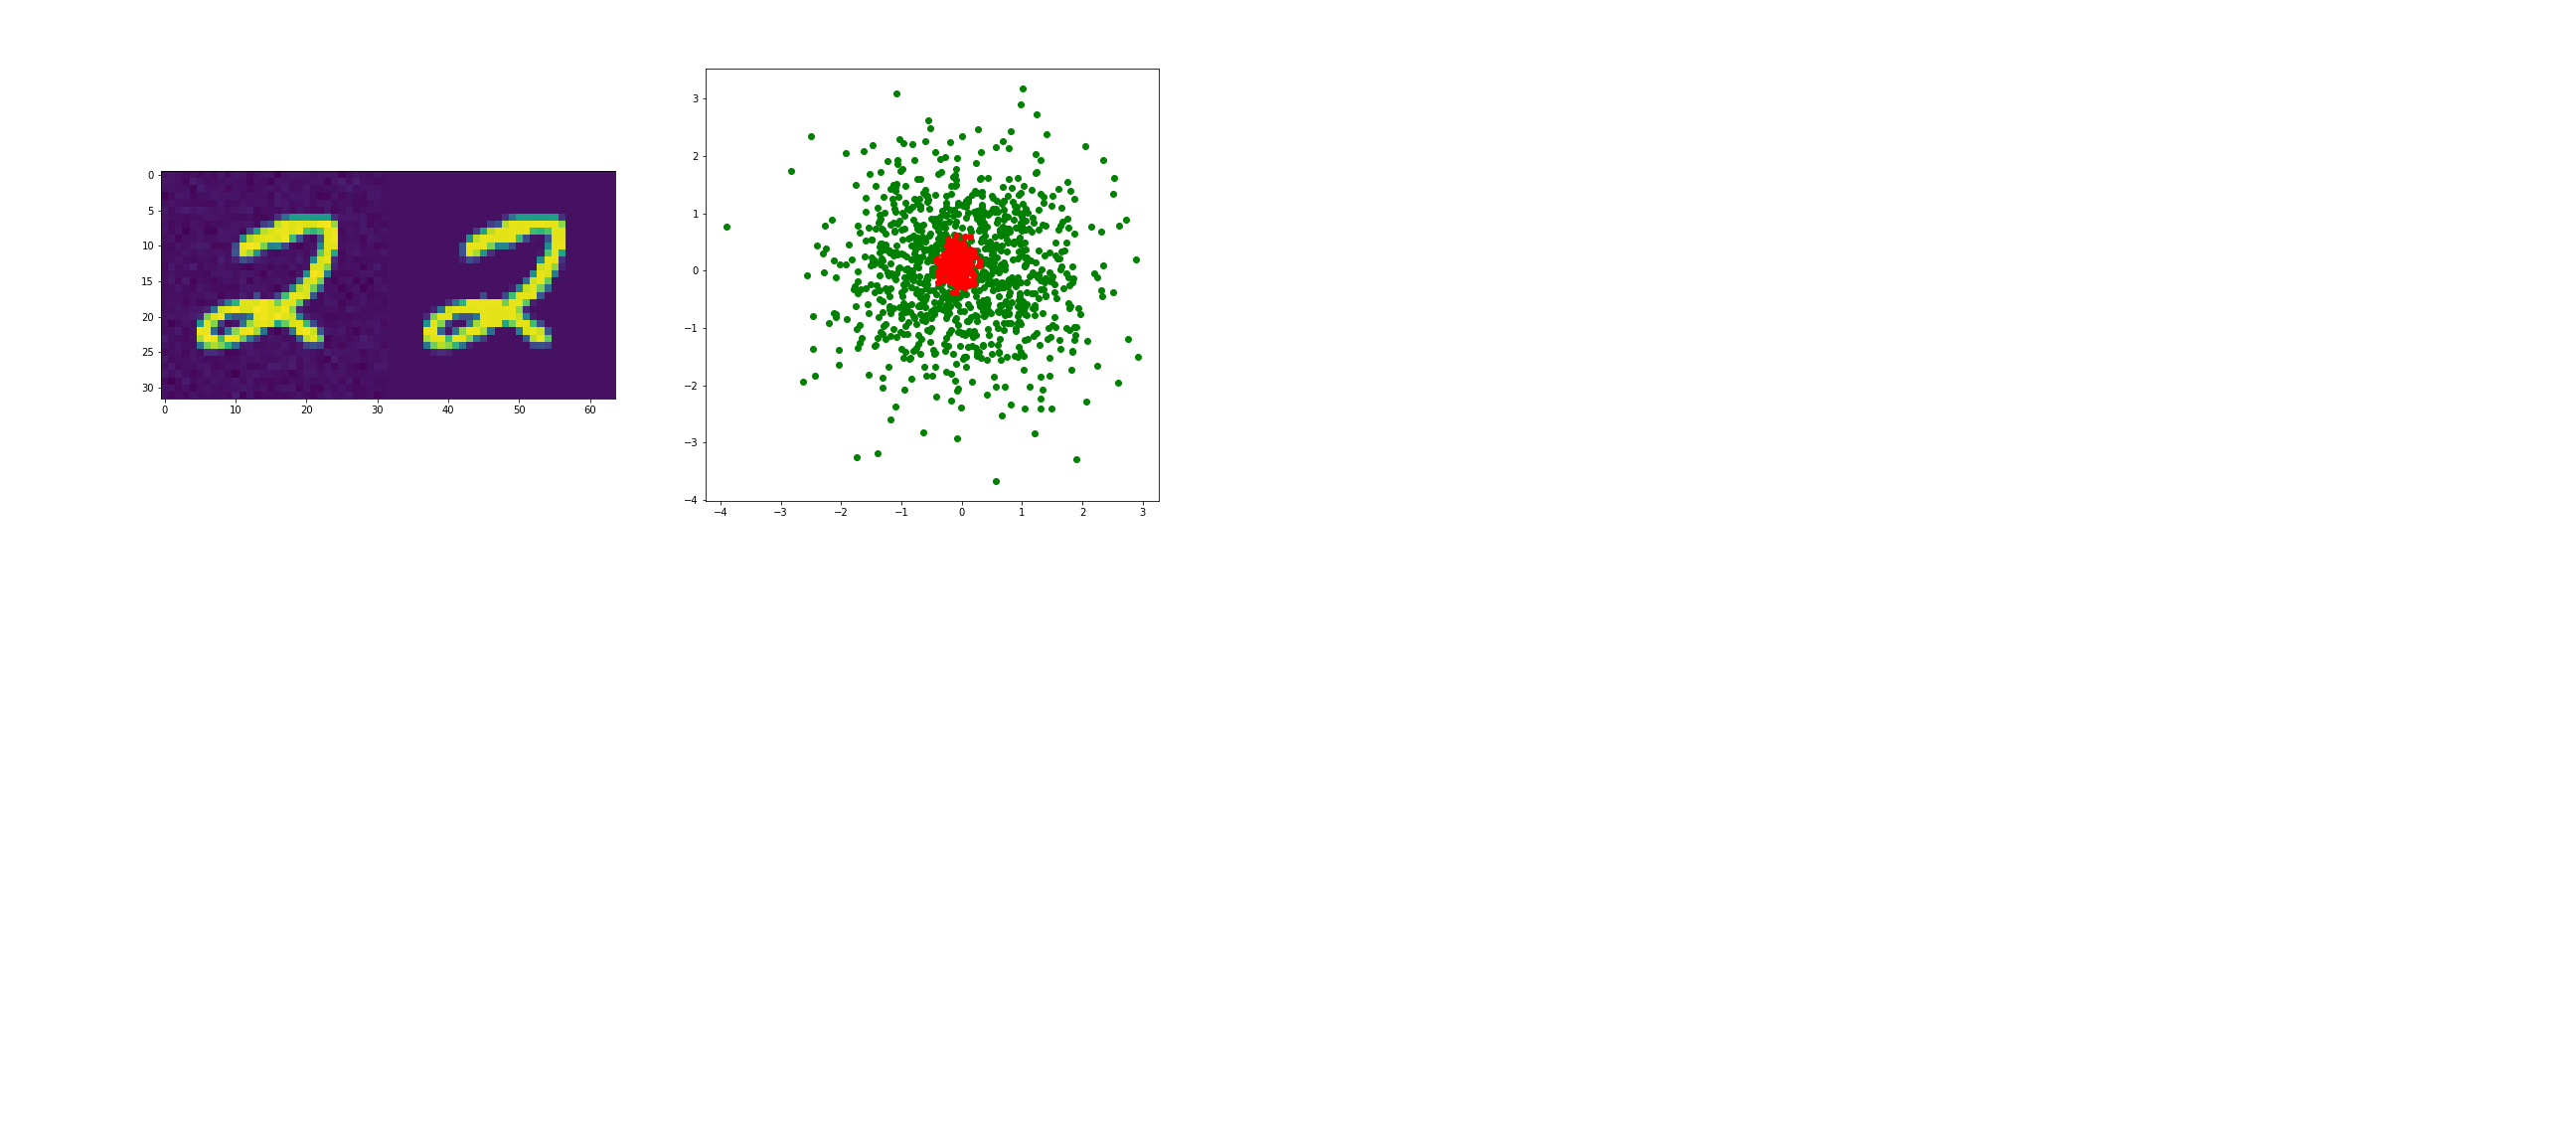

A Jupyter Widget

loss:-0.1642, logdet:0.6419 pz:-0.4777 
loss:-0.3328, logdet:0.6460 pz:-0.3132 
loss:-0.4051, logdet:0.7005 pz:-0.2954 
loss:-0.4896, logdet:0.7682 pz:-0.2786 
loss:-0.5655, logdet:0.8359 pz:-0.2704 
loss:-0.6374, logdet:0.9073 pz:-0.2699 
loss:-0.7050, logdet:0.9832 pz:-0.2782 
loss:-0.7453, logdet:1.0579 pz:-0.3126 
loss:-0.7832, logdet:1.1154 pz:-0.3323 
loss:-0.8273, logdet:1.1652 pz:-0.3378 
loss:-0.8594, logdet:1.2235 pz:-0.3640 
loss:-0.8594, logdet:1.2235 pz:-0.3640 latentstd:0.6020  recon_loss:0.0009
loss:-0.9004, logdet:1.2654 pz:-0.3649 
loss:-0.9395, logdet:1.3188 pz:-0.3793 
loss:-0.9751, logdet:1.3711 pz:-0.3959 
loss:-0.9771, logdet:1.4068 pz:-0.4297 
loss:-1.0284, logdet:1.4139 pz:-0.3855 
loss:-1.0489, logdet:1.4860 pz:-0.4371 
loss:-1.0280, logdet:1.4921 pz:-0.4641 
loss:-1.0935, logdet:1.5002 pz:-0.4067 
loss:-1.0803, logdet:1.5660 pz:-0.4857 
loss:-1.1061, logdet:1.5566 pz:-0.4505 
loss:-1.1061, logdet:1.5566 pz:-0.4505 latentstd:0.7108  recon_loss:0.0010
loss:-1.13

In [ ]:
%matplotlib notebook
fig,(ax,ax2) = plt.subplots(1,2,figsize=(18,8))
axim = None
axscatter = None
fig.canvas.draw()

use_normal = True
test_aucs = []
train_aucs = []
pred_losses = []
pzes = []
logdets = []
losses = []
latent_numpys =[]
def torchSigWMW( target,pred, beta=8):    
    mask = target.type(torch.cuda.ByteTensor)
    x = torch.masked_select(pred, 1+(-1)*mask).view(1,-1)
    y = torch.masked_select(pred, mask).view(-1,1)
    xn = x.expand(y.size(0), x.size(1))
    yn = y.expand(y.size(0), x.size(1))
    ur = torch.sigmoid(-beta*(xn-yn))
    return torch.sum(ur) / torch.sum(target) / torch.sum(1-target)

def criterion(pred, target):
    # return ((pred - (target * dist * 2 - dist)) ** 2).mean() 
    return torchSigWMW(target, pred)


for epoch in tqdm(range(0,10)):  
    itercount = 0
    for inp, _ in trainloader:
        
        net.train()
        optim.zero_grad()
        inp = inp.cuda()
        latent, logdet = net(inp + torch.randn_like(inp).cuda() / (2 ** n_bins)  , return_logdet=True, num_logdet_iter=1) 
        logdet /= inp.shape[2] * inp.shape[3]
        latentstd = torch.mean(torch.cat([l.view(inp.shape[0], -1) for l in latent], dim=1).std(dim=0))

        pz = 0
        for l in latent:
            pz += -((l.view(inp.shape[0], -1)) ** 2).sum(dim=1) / 2 
            
        pz = pz.mean()
        pz /= inp.shape[2] * inp.shape[3]
        
        
        print ('loss:{:.4f}, logdet:{:.4f} pz:{:.4f} '.format(
                -logdet.item()-pz.item(), logdet.item(),pz.item()))
        ( - logdet - pz).backward()

        pzes.append(pz.item())
        logdets.append(logdet.item())
        losses.append((-logdet-pz).item())
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        optim.step()

        if itercount % 10 == 0:
            net.eval()
            latents = []
            for test_batch, _ in testloader:
                test_batch = test_batch.cuda()
                latent = net(test_batch + torch.randn_like(test_batch).cuda() / (2 ** n_bins), return_logdet=False)
                break
                

            with torch.no_grad():
                pred = net([l[:1] for l in latent], reverse=True)
            
            latent_numpy = torch.cat([l.contiguous().view(test_batch.shape[0], -1) for l in latent], dim=1).detach().cpu().numpy()

            recon_loss = F.mse_loss(test_batch[:1], pred)
            if itercount >0:
                print ('loss:{:.4f}, logdet:{:.4f} pz:{:.4f} latentstd:{:.4f}  recon_loss:{:.4f}'.format(
                -logdet.item()-pz.item(), logdet.item(),pz.item(), latentstd.item(),  recon_loss.item()))



            pred_np = pred[0].cpu().detach().numpy().reshape((32,32))
            inp_np = test_batch[0].cpu().detach().numpy().reshape((32,32))
            disp = np.concatenate([pred_np, inp_np], axis=1)
            if axim:
                axim.set_data(disp)
            else:
                axim = ax.imshow(disp)


            ax2.clear()
            ax2.scatter(normal_np[:1000,0], normal_np[:1000,1], c='g')            
            ax2.scatter(latent_numpy[:1000,0], latent_numpy[:1000,1],  c='r')  
            fig.canvas.draw()
            latent_numpys.append(latent_numpy)
        itercount += 1
        del pz,  logdet, latent, latentstd
    #with torch.no_grad():
    #    for name, param in net.named_parameters():
    #        if '.weight' in name:
    #            param /= torch.sqrt((param ** 2).sum())

In [ ]:
latent_numpys = np.array(latent_numpys)

In [ ]:
dists = torch.from_numpy(np.array([[dist,-dist], [dist, dist], [-dist, dist], [-dist,-dist]]).astype(np.float32)).cuda()

In [ ]:
latent_numpys.shape

In [ ]:
latent_numpys = latent_numpys.reshape((-1,80,2560,2))

In [ ]:
latent_numpy = latent_numpys[0,-1]

In [ ]:
latent_numpy.shape

In [ ]:
np.std(latent_numpy[np.logical_and(latent_numpy[:,0] > 0, latent_numpy[:,1] < 0)], axis=0)

In [ ]:
np.mean(latent_numpy[np.logical_and(latent_numpy[:,0] < 0, latent_numpy[:,1] < 0)], axis=0)

In [ ]:
%matplotlib notebook
fig,ax =  plt.subplots(1,1,figsize=(8,8))
def scroll(event):
    global i, latent_numpys
    oldi = i
    if event.key == 'e':
        i -= 1
    elif event.key =='d':
        i += 1
    if i < 0: i = 0
    if i >= len(latent_numpys[0]) - 0: i = len(latent_numpys[0]) - 1
    if oldi != i:
        ax.clear()
        latent_numpy = latent_numpys[0][i][-1]
        
        ax.clear()
        _ = ax.hist(latent_numpys[0][i][:,1], bins=100, density=True)
        _ = ax.hist(normal_np[:,1], bins=100, density=True)
        
        fig.canvas.draw()
        #ax.set_xlim(-3,3)
        #ax.set_ylim(-3,3)


cid1 = fig.canvas.mpl_connect('key_press_event', scroll)
i = 0
latent_numpy = latent_numpys[0][i][-1]
ax.clear()
_ = ax.hist(latent_numpys[0][i][:,1], bins=100, density=True)
_ = ax.hist(normal_np[:,1], bins=100, density=True)


fig.canvas.draw()
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)


In [ ]:
%matplotlib notebook
fig,ax =  plt.subplots(1,1,figsize=(8,8))
def scroll(event):
    global i, latent_numpys
    oldi = i
    if event.key == 'e':
        i -= 1
    elif event.key =='d':
        i += 1
    if i < 0: i = 0
    if i >= len(latent_numpys[0]) - 0: i = len(latent_numpys[0]) - 1
    if oldi != i:
        ax.clear()
        latent_numpy = latent_numpys[0,i]
        
        ax.clear()
        ax.scatter(normal_np[:,0], normal_np[:,1], c='g') 
        ax.scatter(latent_numpy[:500,0], latent_numpy[:500,1],  c='r')  
        fig.canvas.draw()
        #ax.set_xlim(-3,3)
        #ax.set_ylim(-3,3)


cid1 = fig.canvas.mpl_connect('key_press_event', scroll)
i = 0
latent_numpy = latent_numpys[0,i]
ax.clear()
ax.scatter(normal_np[:,0], normal_np[:,1], c='g')
ax.scatter(latent_numpy[:500,0], latent_numpy[:500,1],  c='r')  
fig.canvas.draw()
#ax.set_xlim(-3,3)
#ax.set_ylim(-3,3)

In [ ]:
%matplotlib inline
plt.plot(range(len(losses[:])), losses[:])

In [ ]:
%matplotlib inline
plt.plot(range(len(logdets[:])), logdets[:])

In [ ]:
%matplotlib inline
plt.plot(range(len(pzes[250:])), pzes[250:])